In [ ]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, BoundaryNorm

In [ ]:
class ClimateNetTools():
    @staticmethod
    def plot_labels(ds, ax=None, show=True):
        labels = ds['LABELS']
        unique_labels = np.unique(labels.values)
        unique_labels = unique_labels[~np.isnan(unique_labels)]  # remove nan if present

        colors = plt.cm.BuPu(np.linspace(0, 1, len(unique_labels)))
        cmap = ListedColormap(colors)
        bounds = list(range(int(min(unique_labels)), int(max(unique_labels)) + 2))
        norm = BoundaryNorm(bounds, cmap.N)

        if ax is None:
            plt.figure(figsize=(20, 9))
            ax = plt.axes(projection=ccrs.PlateCarree())

        im = labels.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,
                         cbar_kwargs={'label': 'Labels', 'ticks': [b + 0.5 for b in bounds[:-1]],
                                      'boundaries': bounds, 'spacing': 'proportional'})
        ax.coastlines()
        ax.set_title('Visualization of Labels')

        label_descriptions = {0: 'BG', 1: 'TC', 2: 'AR'}
        if show:
            cbar = plt.gcf().axes[-1]
            cbar.set_yticklabels([label_descriptions[i] for i in unique_labels])
            plt.show()
        return ax

    @staticmethod
    def plot_iwv(ds, ax=None, show=True):
        iwv = ds['TMQ']
        if ax is None:
            plt.figure(figsize=(20, 9))
            ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-160))
        iwv.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', vmin=0, vmax=60, cbar_kwargs={'label': 'IWV (kg/m^2)'})
        ax.coastlines()
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_title('Integrated Water Vapor (IWV)')

        contour_levels = np.arange(iwv.min(), iwv.max(), 10)
        contours = plt.contour(iwv.lon, iwv.lat, iwv.squeeze(), levels=contour_levels, colors='#222222', linewidths=0.3, transform=ccrs.PlateCarree())
        plt.clabel(contours, inline=True, fontsize=8, fmt='%d')
        if show:
            plt.show()
        return ax

    @staticmethod
    def plot_iwv_AR(ds, show=True):
        labels = ds['LABELS']

        plt.figure(figsize=(20, 9))
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-160))

        # Plot IWV
        ClimateNetTools.plot_iwv(ds, ax=ax, show=False)

        # Overlay AR contours from labels
        label_descriptions = {0: 'BG', 1: 'TC', 2: 'AR'}
        colors = {2: 'white'}
        for label_value in np.unique(labels.values):
            if label_value != 2:
                continue
            mask = (labels == label_value).squeeze()
            ax.contour(
                labels.lon, labels.lat, mask,
                levels=[0.5], colors=colors.get(label_value, 'red'),
                linewidths=2, transform=ccrs.PlateCarree(),
                label=label_descriptions.get(label_value, str(label_value))
            )

        # Add legend manually
        legend_elements = [
            Line2D([0], [0], color=colors.get(i, 'red'), lw=2, label=label_descriptions.get(i, str(i)))
            for i in np.unique(labels.values) if i != 0 and not np.isnan(i)
        ]
        ax.legend(handles=legend_elements, loc='lower left')
        if show:
            plt.show()
        return ax

In [28]:
file_path = "data\src\ClimateNet\data-2012-10-18-01-1_0.nc"
ds = xr.open_dataset(file_path, engine="netcdf4")
ds

<xarray.Dataset> Size: 64MB
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * time     (time) <U23 92B 'data-2012-10-18-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 4MB ...
    U850     (time, lat, lon) float32 4MB ...
    V850     (time, lat, lon) float32 4MB ...
    UBOT     (time, lat, lon) float32 4MB ...
    VBOT     (time, lat, lon) float32 4MB ...
    QREFHT   (time, lat, lon) float32 4MB ...
    ...       ...
    TS       (time, lat, lon) float32 4MB ...
    TREFHT   (time, lat, lon) float32 4MB ...
    Z1000    (time, lat, lon) float32 4MB ...
    Z200     (time, lat, lon) float32 4MB ...
    ZBOT     (time, lat, lon) float32 4MB ...
    LABELS   (lat, lon) int64 7MB ...

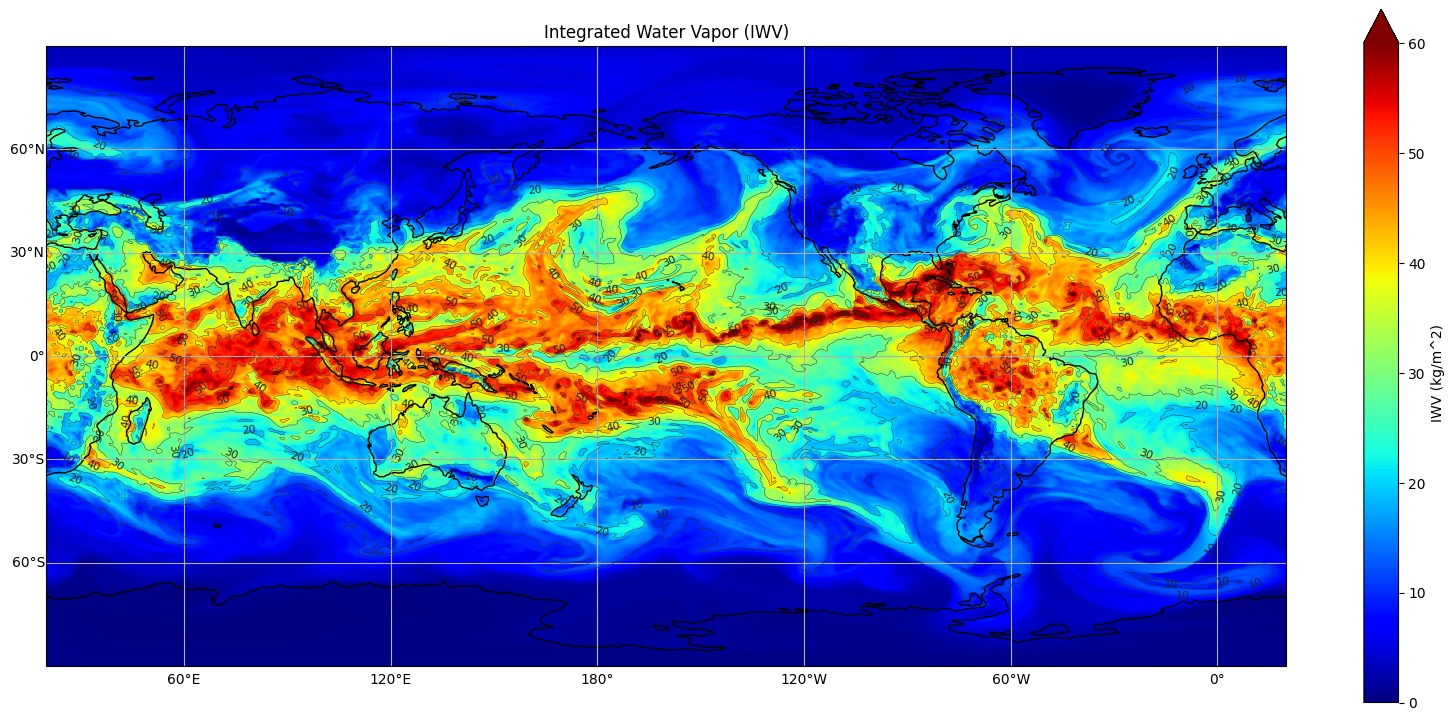

<GeoAxes: title={'center': 'Integrated Water Vapor (IWV)'}, xlabel='lon', ylabel='lat'>

In [29]:
ClimateNetTools.plot_iwv(ds)

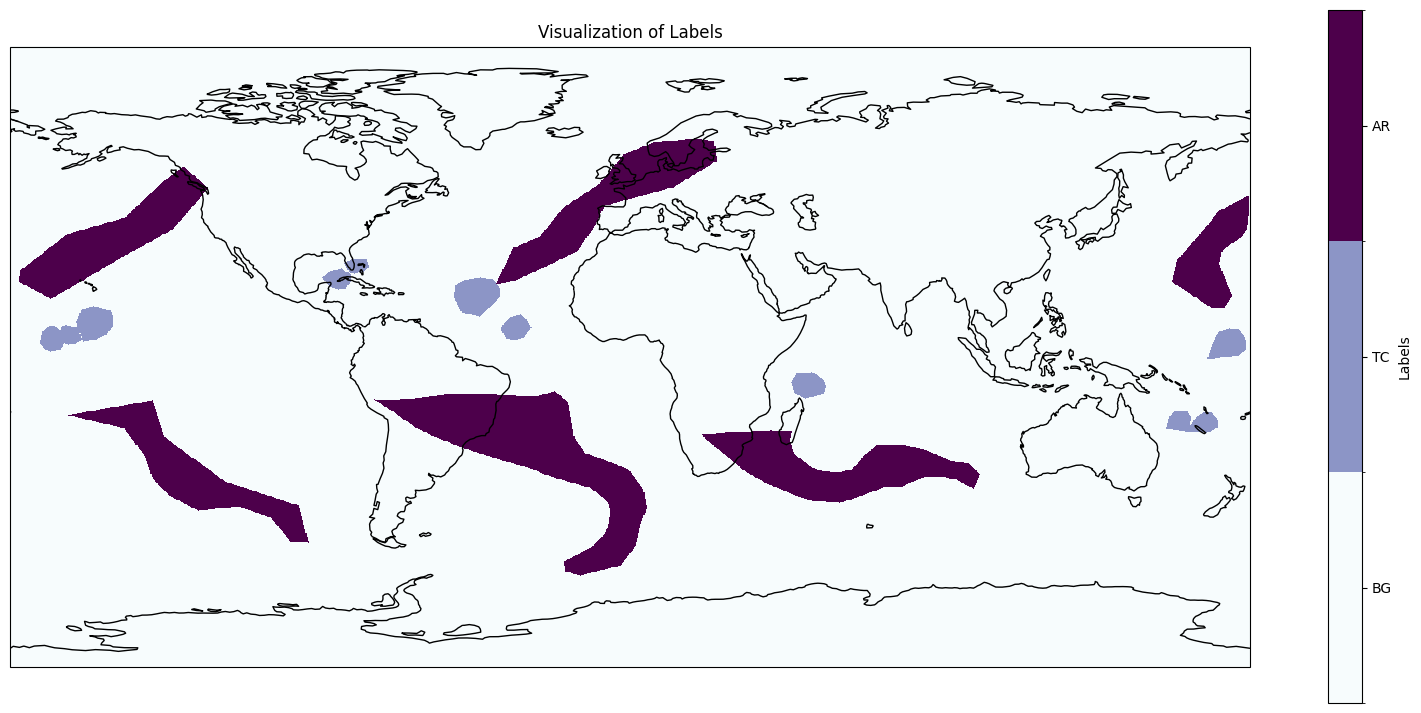

<GeoAxes: title={'center': 'Visualization of Labels'}, xlabel='lon', ylabel='lat'>

In [30]:
ClimateNetTools.plot_labels(ds)

f:\FGGT\4th\AR\AR-detection\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)


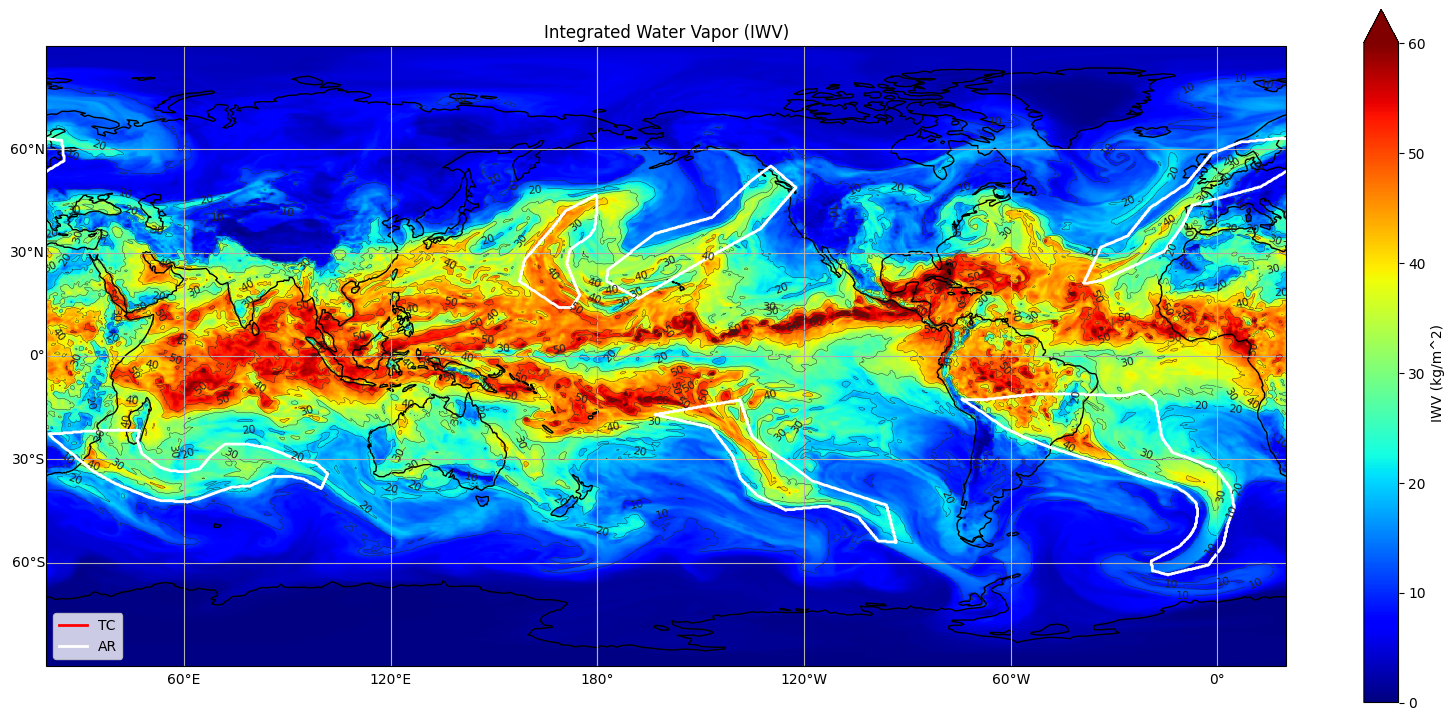

<GeoAxes: title={'center': 'Integrated Water Vapor (IWV)'}, xlabel='lon', ylabel='lat'>

In [31]:
ClimateNetTools.plot_iwv_AR(ds)

In [ ]:
def save_climatenet_plot(ds, plot_type='iwv', save_path='plot.png'):
    """
    Сохраняет график по данным ds с помощью ClimateNetTools.
    plot_type: 'iwv', 'labels', 'iwv_ar'
    save_path: путь для сохранения изображения
    """
    plt.ioff()  # Отключить интерактивный режим для корректного сохранения
    if plot_type == 'iwv':
        ax = ClimateNetTools.plot_iwv(ds, show=False)
    elif plot_type == 'labels':
        ax = ClimateNetTools.plot_labels(ds, show=False)
    elif plot_type == 'iwv_ar':
        ax = ClimateNetTools.plot_iwv_AR(ds, show=False)
    else:
        raise ValueError("plot_type должен быть 'iwv', 'labels' или 'iwv_ar'")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

# save_climatenet_plot(ds, plot_type='iwv_ar', save_path='iwv_ar_plot.png')

In [45]:
from tqdm.auto import tqdm

nc_files = sorted(list(Path("data/src/ClimateNet/").glob("*.nc")))
for nc in tqdm(nc_files):
    save_dir = Path("data/src/ClimateNet/AR_labels")
    save_dir.mkdir(exist_ok=True)
    save_path = Path(save_dir, nc.stem + ".png")
    ds = xr.open_dataset(nc, engine="netcdf4")
    save_climatenet_plot(ds, plot_type='iwv_ar', save_path=save_path)

  0%|          | 0/38 [00:00<?, ?it/s]f:\FGGT\4th\AR\AR-detection\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
  3%|▎         | 1/38 [00:13<08:36, 13.95s/it]f:\FGGT\4th\AR\AR-detection\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
  5%|▌         | 2/38 [00:27<08:23, 13.97s/it]f:\FGGT\4th\AR\AR-detection\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
  8%|▊         | 3/38 [00:42<08:15, 14.15s/it]f:\FGGT\4th\AR\AR-detection\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
 11%|█         | 4/38 [00:56<08:05, 14.27s/it]f:\FGG